In [1]:
import allel
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pysam import VariantFile
from tqdm import tqdm
import numpy as np

In [2]:
vcf_dir = "data/1000G/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz"
def allele_indices(vcf_dir, skip_every = 5):
    """
    Given a VCF file, this returns each samples genotype 
    represented as allele indices along with the corresponding
    variant IDs and list of samples.

    Args:
        vcf_dir (string): Location of VCF file.
        skip_every (int): Only return every other "skip_every"
            variant. This may be useful if you are running this
            with less than 16GB of RAM.

    Returns:
        list: List of each sample.
        list: Genotypes of shape: (samples, num_variants // skip_every, 2).
        list: Variant IDs for each variant.

    """
    vcf_file = VariantFile(vcf_dir)

    samples = list(vcf_file.header.samples)

    genotypes = []
    variant_ids = []
    for counter, record in tqdm(enumerate(vcf_file.fetch())):
        if counter % skip_every == 0:
            alleles = [record.samples[x].allele_indices for x in samples]

            genotypes.append(alleles)
            variant_ids.append(record.id)

    return samples, genotypes, variant_ids

In [3]:
panel_dir = "data/1000G/integrated_call_samples_v3.20130502.ALL.panel"
def parse_panel(panel_dir):
    """
    Returns python dictionaries that maps each sample
    to a population and superpopulation. 

    Args:
        panel_dir (string): Location of the panel file 
            containing information about each sample.

    Returns:
        dict: Population map for each sample. For
            example, {sample_id, population}.

        dict: Superpopulation map for each sample. For
            example, {sample_id, superpopulation}.

    """
    population_map = {}  
    superpopulation_map = {}  
    with open(panel_dir) as panel_file:
        for sample in panel_file:
            """
            EX: ["HG00607", "CHS", "ASN", "ILLUMINA"]

            sample[0] = Sample ID.
            sample[1] = Population.
            sample[2] = Superpopulation.

            """
            sample = sample.strip().split('\t')

            population_map[sample[0]] = sample[1]
            superpopulation_map[sample[0]] = sample[2]
    
    return population_map, superpopulation_map 

In [4]:
skip_every = 25
samples, genotypes, variant_ids = allele_indices(vcf_dir, skip_every)
population_map, superpopulation_map = parse_panel(panel_dir)

# Find the superpopulation of each sample.
superpopulation = pd.Series(samples).map(superpopulation_map)

# Prepare the data for dimensionality reduction.
# shape: (samples, variant_count // skip_every, 2)
genotypes = np.array(genotypes)
genotypes = np.sum(genotypes, axis = 2)

1103547it [01:38, 11166.17it/s]


In [5]:
# No scale data
genotypes = genotypes[::10]
genotypes

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Text(0.5, 1.0, 'Visualization of row data')

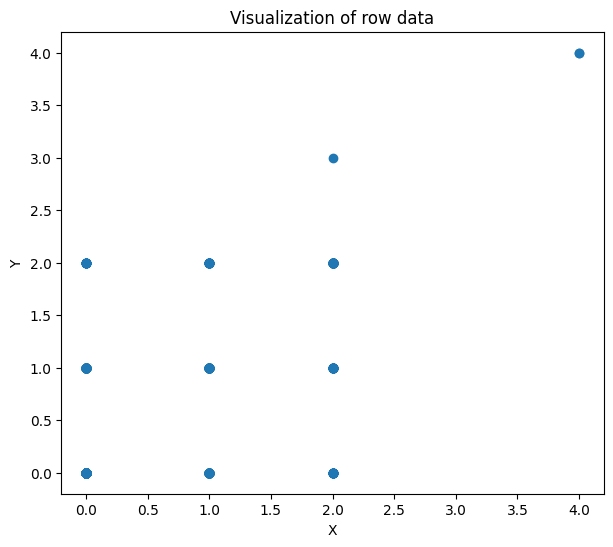

In [6]:
plt.figure(figsize=(7,6))
plt.scatter(genotypes[:,100], genotypes[:, 1000])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Visualization of row data')

In [7]:
# Scale data 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
genotypes_scaled = scaler.fit_transform(genotypes)

In [8]:
m, n = genotypes.shape

print(f"Shape: ({m}, {n})")
print(f"New Number of Obervations: {m}")
print(f"New Number of Features: {n}")

Shape: (4415, 2504)
New Number of Obervations: 4415
New Number of Features: 2504


In [9]:
# Calculate the mean.
mean = np.mean(genotypes, axis = 1, keepdims = True)

# Subtract the mean.
genotypes_normalized = genotypes - mean

# Compute the covariance matrix of our data.
covariance = genotypes_normalized.dot(genotypes_normalized.T) / (n - 1)

eig_values, eig_vectors = np.linalg.eigh(covariance)

# They are in ascending order, we want the opposite.
eig_values = eig_values[::-1]
eig_vectors = eig_vectors[:, ::-1]

print(eig_values.shape)
print(eig_vectors.shape)

np.cumsum(eig_values / np.sum(eig_values))[0 : 10]

pc1 = eig_vectors[:, 0]
pc2 = eig_vectors[:, 1]

pc1_plot = genotypes_normalized.T.dot(pc1)
pc2_plot = genotypes_normalized.T.dot(pc2)

(4415,)
(4415, 4415)


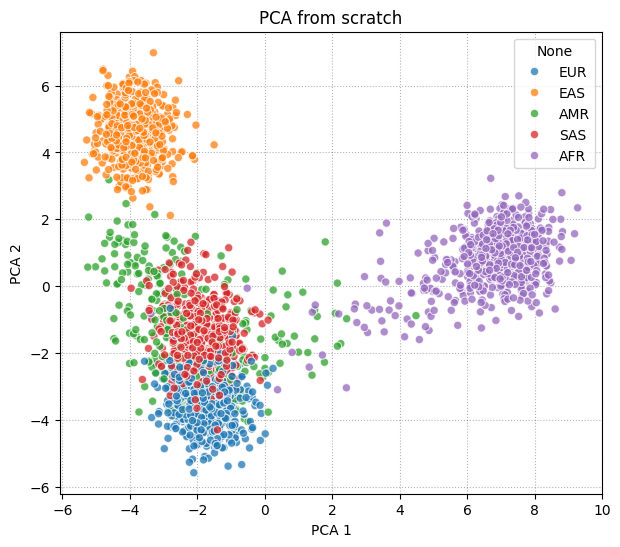

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (7, 6))

sns.scatterplot(
    x = pc1_plot, 
    y = pc2_plot, 
    hue = superpopulation,
    alpha = 0.75, 
    zorder = 2,
    linewidth = 0.75,
    ax = ax
)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_facecolor('white')
ax.grid(True, alpha = 0.3, color = "black", linestyle = "dotted", zorder = 1)
plt.title('PCA from scratch')
plt.show()

### Cumulative variance plot

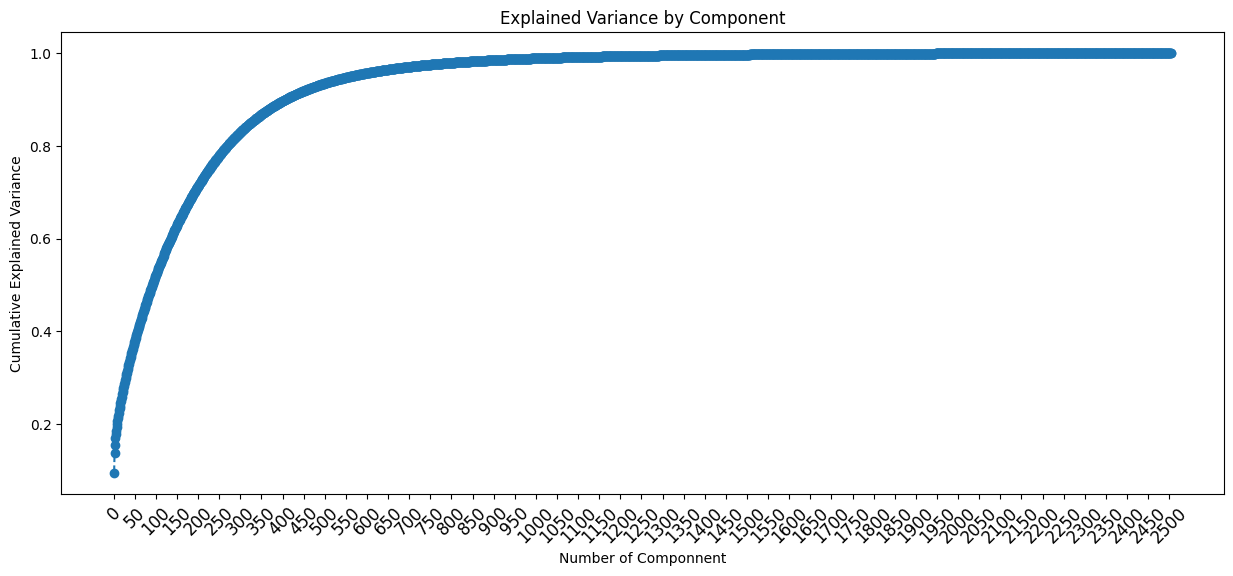

In [11]:
from sklearn.decomposition import PCA

pca_model = PCA()
pca_model.fit(genotypes.T)

explained_variance = pca_model.explained_variance_ratio_

plt.figure(figsize=(15,6))
plt.plot(range(1,2505), explained_variance.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Component')
plt.xlabel('Number of Componnent')
plt.ylabel('Cumulative Explained Variance')

# Adjust x-axis
plt.xticks(fontsize=12)  # Change font size of x-axis labels
plt.xticks(range(0, 2505, 50))  # Adjust tick frequency (every 100 components)
plt.tick_params(axis='x', rotation=45)  # Rotate x-axis labels by 45 degrees

plt.show()

Therefore, the rule of thumb is to perserve around 80% of the variance. So, we decide to keep 275 components.
#what threshold should we take? 80% or 95%?

In [12]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components = 275)
pca_model.fit(genotypes.T)
reduce_data_pca = pca_model.fit_transform(genotypes.T)

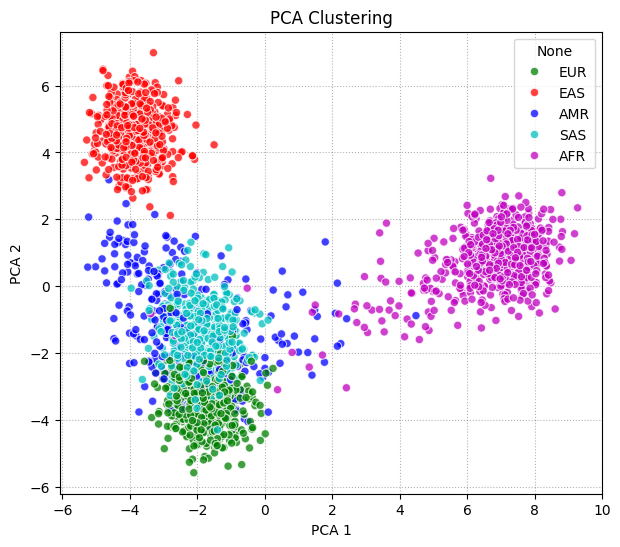

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (7, 6))
sns.scatterplot(
    x = reduce_data_pca[:, 0], #take only first two dimension 
    y = reduce_data_pca[:, 1], 
    hue = superpopulation, 
    palette=['g', 'r', 'b', 'c', 'm'],
    alpha = 0.75, 
    zorder = 2,
    linewidth = 0.75,
    ax = ax
)
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_facecolor('white')
ax.grid(True, alpha = 0.3, color = "black", linestyle = "dotted", zorder = 1)
plt.title("PCA Clustering")
plt.show()

In [14]:
variance_captured = np.cumsum(pca_model.explained_variance_ratio_)[-1]
print(f"Percentage of variance captured with {pca_model.n_components} components: {variance_captured:0.4f}")

Percentage of variance captured with 275 components: 0.8036


### Elbow Method

/home/tmenghor/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/tmenghor/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/tmenghor/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/tmenghor/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'au

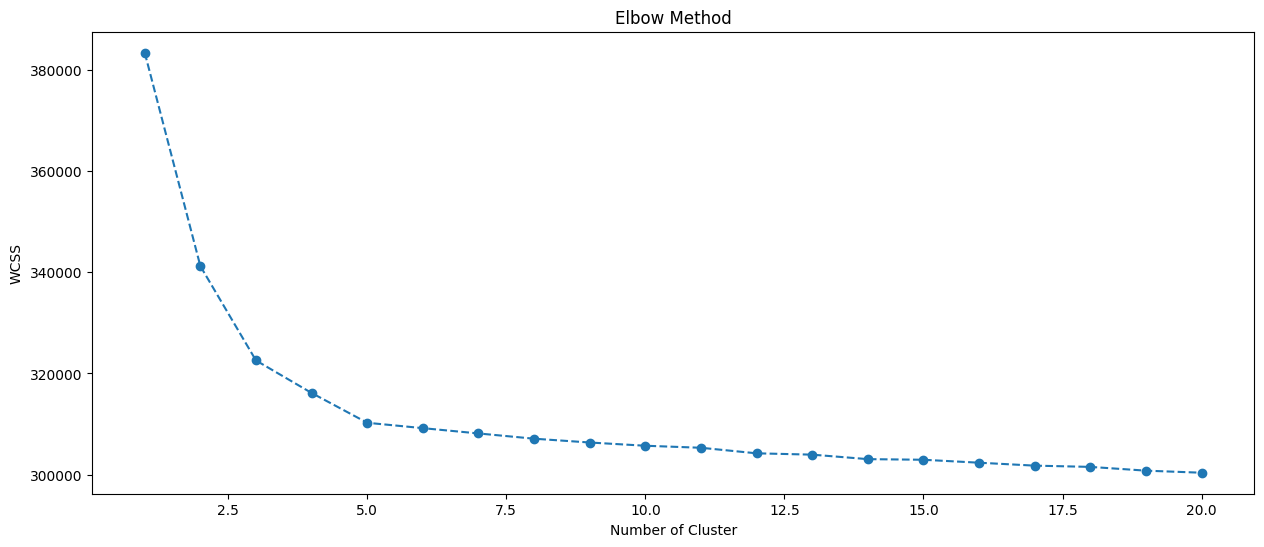

In [15]:
from sklearn.cluster import KMeans
pca_model = PCA(n_components=275)
pca_model.fit(genotypes.T)
scores_pca = pca_model.transform(genotypes.T) #genotypes or genotypes.T

#within-cluster sum of squares (WCSS)
wcss = []
for i in range(1,21):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

plt.figure(figsize=(15,6))
plt.plot(range(1,21), wcss, marker='o', linestyle = '--')
plt.xlabel('Number of Cluster')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

### Kmeans without pca

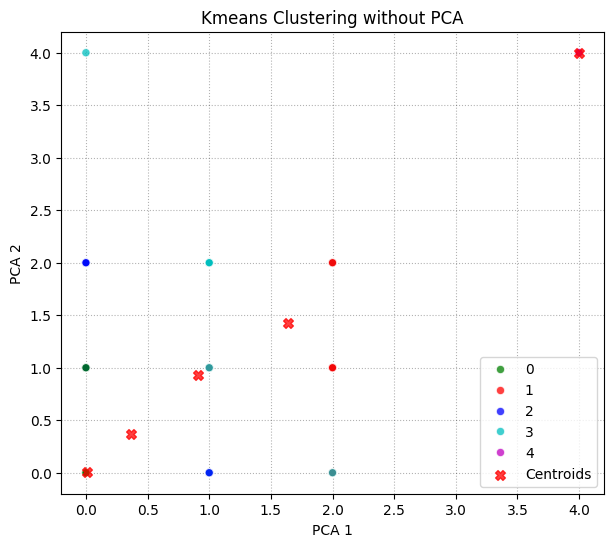

In [22]:
# Apply K-Means without PCA
cluster_model = KMeans(n_clusters = 5, max_iter = 10000, n_init = 25, random_state=5)
kmeans_labels = cluster_model.fit_predict(genotypes)

# centers = cluster_model.cluster_centers_
centers_reduced = cluster_model.cluster_centers_

fig, ax = plt.subplots(1, 1, figsize = (7, 6))
sns.scatterplot(
    x = genotypes[:, 0], 
    y = genotypes[:, 1], 
    hue = kmeans_labels, 
    palette=['g', 'r', 'b', 'c', 'm'],
    alpha = 0.75, 
    zorder = 2,
    linewidth = 0.75,
    ax=ax
)

plt.scatter(centers_reduced[:, 0], centers_reduced[:, 1], c='red', s=50, alpha=0.75, marker='X', label='Centroids', zorder=3 )

# ax.set_xlabel("PCA 1")
# ax.set_ylabel("PCA 2")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
#ax.set_facecolor('white')
ax.grid(True, alpha = 0.3, color = "black", linestyle = "dotted", zorder = 1)
plt.title("Kmeans Clustering without PCA")
plt.legend()
plt.show()

### Kmeans with PCA

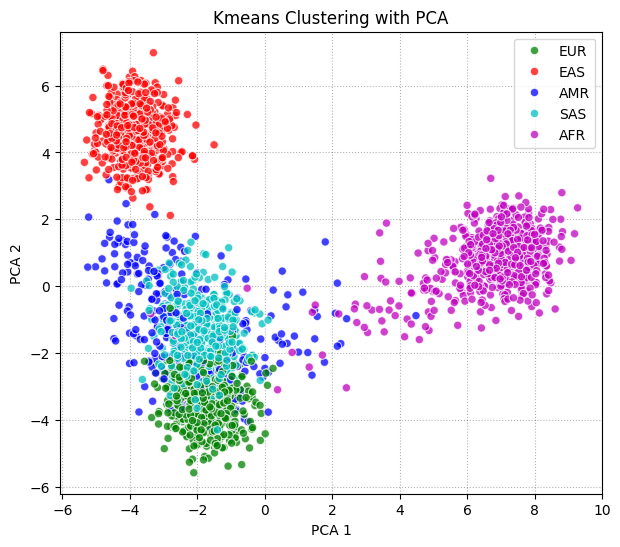

In [53]:
from sklearn.cluster import KMeans

pca_model = PCA(n_components = 275) #reduce data to 275components cuz it visibly distints 
reduced_data_pca = pca_model.fit_transform(genotypes.T)

kmeans_model = KMeans(n_clusters = 5, max_iter = 10000, n_init = 25, random_state=5)
kmeans_labels = kmeans_model.fit_predict(genotypes.T)

fig, ax = plt.subplots(1, 1, figsize = (7, 6))
sns.scatterplot(
    x = reduced_data_pca[:, 0], 
    y = reduced_data_pca[:, 1], 
    hue = superpopulation, #kmeans_labels
    palette=['g', 'r', 'b', 'c', 'm'],
    alpha = 0.75, 
    zorder = 2,
    linewidth = 0.75,
    ax = ax
)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_facecolor('white')
ax.grid(True, alpha = 0.3, color = "black", linestyle = "dotted", zorder = 1)
plt.title("Kmeans Clustering with PCA")
plt.legend()
plt.show()


#### Silhouette Score

In [54]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
labels = kmeans_model.labels_
# Calculate the silhouette score
sil_score = silhouette_score(genotypes.T, labels)
print(f"Silhouette Score: {sil_score:.4f}")
dbi = davies_bouldin_score(genotypes.T, labels)
print(f"Davies-Bouldin Index: {dbi:.4f}")

Silhouette Score: 0.0532
Davies-Bouldin Index: 4.0802


clusters are poorly separated

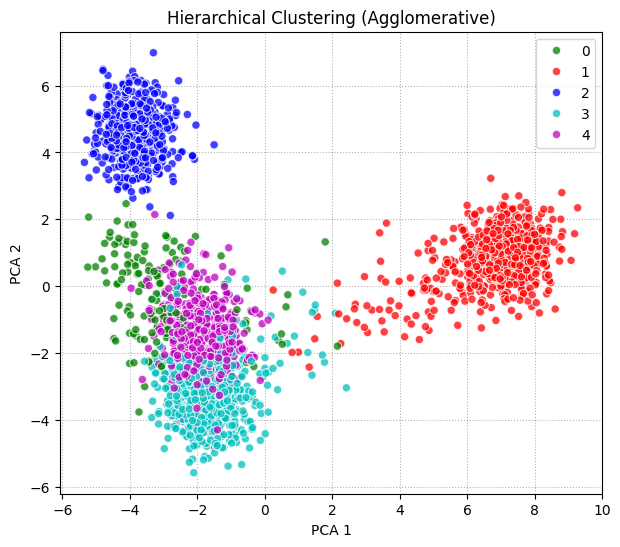

In [26]:
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns

reduced_data_pca = pca_model.fit_transform(genotypes.T)  # Réduit `genotypes` à 128 dimensions comme avant.

# Étape 2 : Hierarchical Clustering (Agglomerative)
hierarchical_model = AgglomerativeClustering(n_clusters=5, linkage='ward')
hierarchical_labels = hierarchical_model.fit_predict(reduced_data_pca)  # Génère les clusters

# Étape 3 : Visualisation des clusters
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

sns.scatterplot(
    x=reduced_data_pca[:, 0],  # Première composante principale (PCA 1)
    y=reduced_data_pca[:, 1],  # Deuxième composante principale (PCA 2)
    hue=hierarchical_labels,  # Labels des clusters par Hierarchical Clustering
    palette=['g', 'r', 'b', 'c', 'm'],  # Palette de couleurs
    alpha=0.75, 
    zorder=2,
    linewidth=0.75,
    ax=ax
)

# Ajouter des axes, légendes et autres détails
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_facecolor('white')
ax.grid(True, alpha=0.3, color="black", linestyle="dotted", zorder=1)

plt.title("Hierarchical Clustering (Agglomerative)")
plt.show()

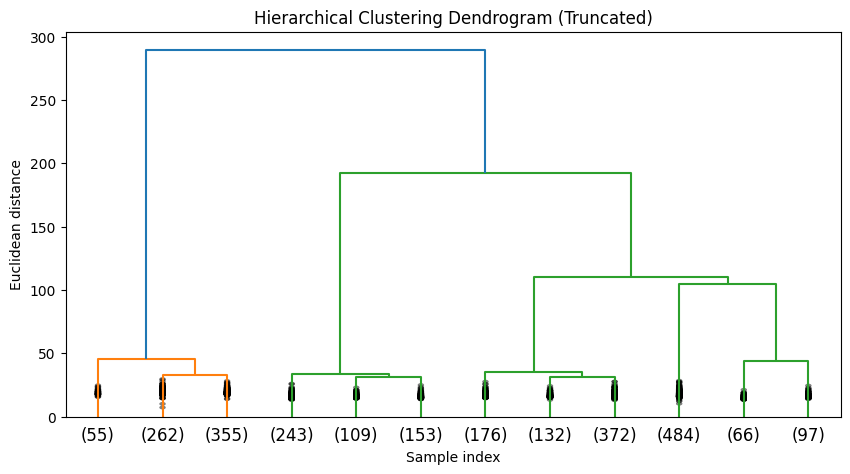

In [52]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Compute the linkage matrix for hierarchical clustering
Z = linkage(genotypes.T, 'ward')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode='lastp', p=12, show_leaf_counts=True, show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (Truncated)')
plt.xlabel('Sample index')
plt.ylabel('Euclidean distance')
plt.show()

In [47]:
#Silhouette score
labels = hierarchical_model.labels_
# Calculate the silhouette score
sil_score = silhouette_score(genotypes.T, labels)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.0520


### Chosing Min. Samples and Epsilon

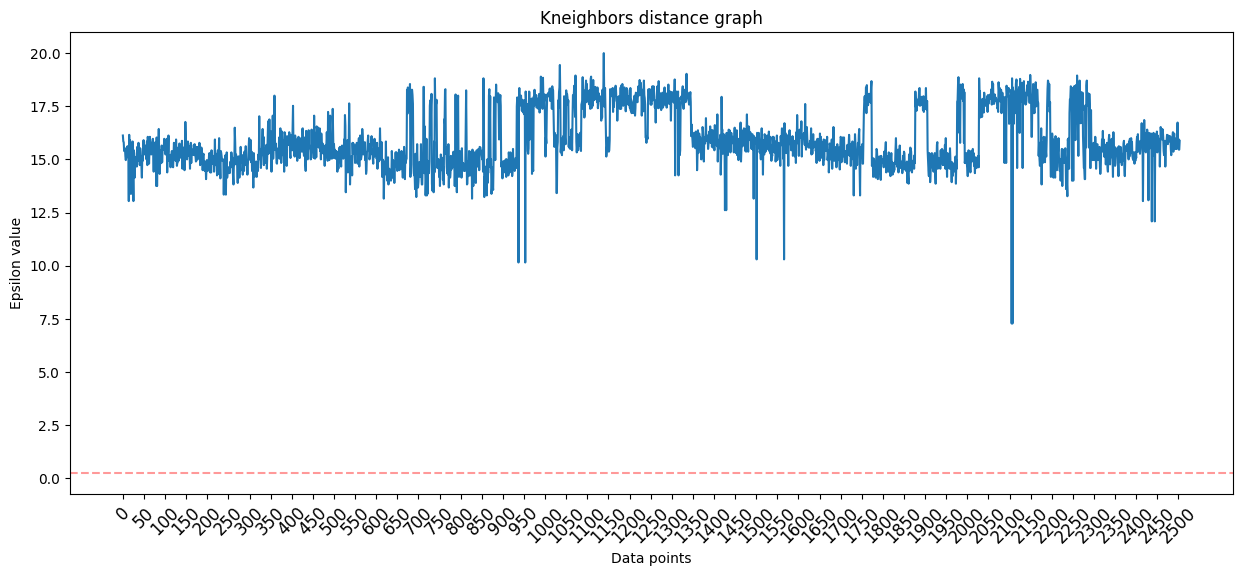

In [27]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=2503) # minimum points -1
nbrs = nn.fit(genotypes.T)
distances, indices = nbrs.kneighbors(genotypes.T)

istances = np.sort(distances, axis=0)
distances = distances[:,1] # Choosing only the smallest distances

plt.figure(figsize=(15,6))
plt.plot(distances)
plt.axhline(y=0.24, color='r', linestyle='--', alpha=0.4) # elbow line
plt.title('Kneighbors distance graph')
plt.xlabel('Data points')
plt.ylabel('Epsilon value')
# Adjust x-axis
plt.xticks(fontsize=12)  # Change font size of x-axis labels
plt.xticks(range(0, 2505, 50))  # Adjust tick frequency (every 100 components)
plt.tick_params(axis='x', rotation=45)  # Rotate x-axis labels by 45 degrees
plt.show()

### BDSCAN

/tmp/ipykernel_47621/858145724.py:12: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


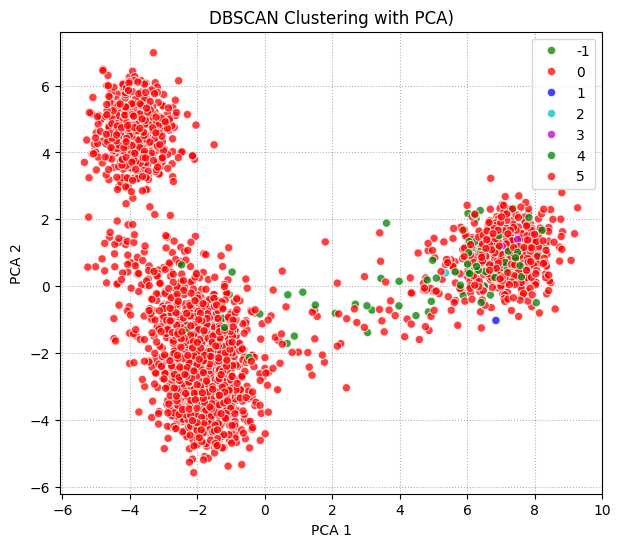

In [56]:
from sklearn.cluster import DBSCAN

reduced_data_pca = pca_model.fit_transform(genotypes.T)  # Réduit `genotypes` à 128 dimensions comme avant.

# Étape 2 : Hierarchical Clustering (Agglomerative)
dbscan_model = DBSCAN(eps=14.72, min_samples=2)
dbscan_labels = dbscan_model.fit_predict(reduced_data_pca)  # Génère les clusters

# Étape 3 : Visualisation des clusters
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

sns.scatterplot(
    x=reduced_data_pca[:, 0],  # Première composante principale (PCA 1)
    y=reduced_data_pca[:, 1],  # Deuxième composante principale (PCA 2)
    hue=dbscan_labels,  # Labels des clusters par Hierarchical Clustering
    palette=['g', 'r', 'b', 'c', 'm'],  # Palette de couleurs
    alpha=0.75, 
    zorder=2,
    linewidth=0.75,
    ax=ax
)

# Ajouter des axes, légendes et autres détails
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_facecolor('white')
ax.grid(True, alpha=0.3, color="black", linestyle="dotted", zorder=1)

plt.title("DBSCAN Clustering with PCA)")

plt.show()

In [29]:
dbscan_model.fit(genotypes.T)  # Fit the model on the transposed DataFrame
labels = dbscan_model.labels_

# Convert the transposed numpy array back to a pandas DataFrame
genotypes_T = pd.DataFrame(genotypes.T)

# Add the labels as a new column
genotypes_T['labels'] = labels

# Display the transposed DataFrame with the labels
genotypes_T.head()

labels_list = list(genotypes_T['labels'])
n_noise = labels_list.count(-1)
print("Number of noise points:", n_noise)

Number of noise points: 2125


In [30]:
total_labels = np.unique(labels)

n_labels = 0
for n in total_labels:
    if n != -1:
        n_labels += 1
print("Number of clusters:", n_labels)

Number of clusters: 38


In [31]:
from sklearn.metrics import silhouette_score

s_score = silhouette_score(genotypes_T, labels)
print(f"Silhouette coefficient: {s_score:.3f}")

Silhouette coefficient: -0.040


### Spectral clustering

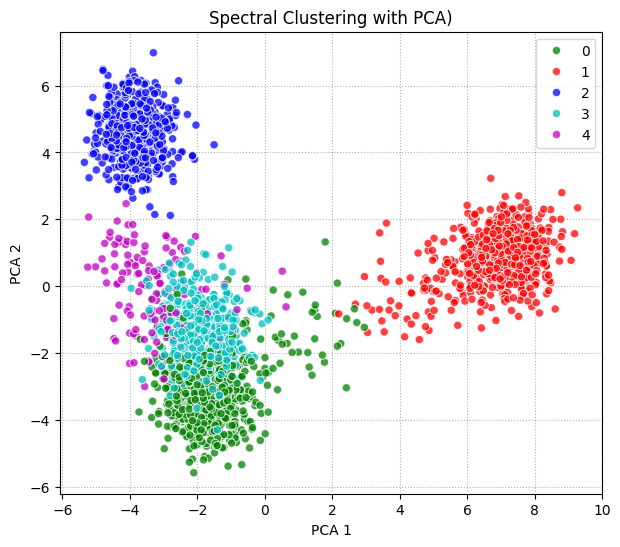

In [50]:
from sklearn.cluster import SpectralClustering 

reduced_data_pca = pca_model.fit_transform(genotypes.T)  # Réduit `genotypes` à 128 dimensions comme avant.

spectral_model = SpectralClustering(n_clusters = 5, affinity ='nearest_neighbors', n_init = 10)

spectral_labels = spectral_model.fit_predict(reduced_data_pca)  # Génère les clusters

# Étape 3 : Visualisation des clusters
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

sns.scatterplot(
    x=reduced_data_pca[:, 0],  # Première composante principale (PCA 1)
    y=reduced_data_pca[:, 1],  # Deuxième composante principale (PCA 2)
    hue=spectral_labels,  # Labels des clusters par Hierarchical Clustering
    palette=['g', 'r', 'b', 'c', 'm'],  # Palette de couleurs
    alpha=0.75, 
    zorder=2,
    linewidth=0.75,
    ax=ax
)

# Ajouter des axes, légendes et autres détails
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_facecolor('white')
ax.grid(True, alpha=0.3, color="black", linestyle="dotted", zorder=1)

plt.title("Spectral Clustering with PCA)")

plt.show()

In [51]:
labels = spectral_model.labels_
# Calculate the silhouette score
sil_score = silhouette_score(genotypes.T, labels)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.0526
